### Import modules

In [1]:
import sys
import os
from numpy import array
from pandas import read_csv, DataFrame, Series, Index, Period
from matplotlib.pyplot import subplots, figure, show, plot, legend
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from statsmodels.tsa.stattools import adfuller

utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import plot_line_chart, HEIGHT, set_chart_labels, plot_multiline_chart


### Load data

In [2]:
data_path = os.path.abspath(os.path.join('..','..', 'data/f_s_forecast_ny_arrests.csv'))

def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col="Date",
        sep=";",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

data = load_data(data_path)

data.head()

,Bronx,Brooklyn,Queens,StatenIsland,Manhattan
Date,,,,,
2006-01-01,110,149,126,14,152
2006-01-02,141,221,101,22,133
2006-01-03,204,236,184,38,237
2006-01-04,287,341,252,47,302
2006-01-05,379,355,227,53,369


### Plot data

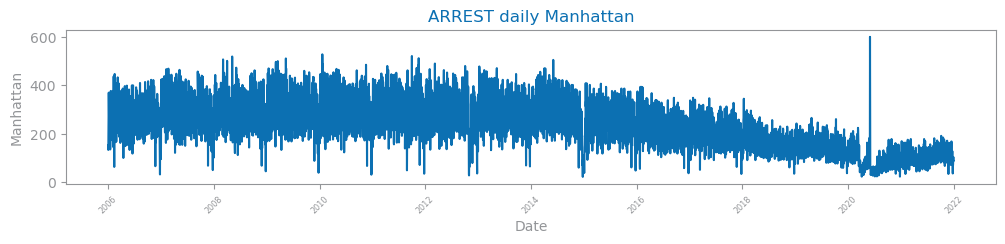

Nr. Records =  (5844, 5)
First timestamp 2006-01-01 00:00:00
Last timestamp 2021-12-31 00:00:00


In [3]:
file_tag = "ARREST"
target = "Manhattan"
series: Series = data[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} daily {target}",
)
show()

print("Nr. Records = ", data.shape)
print("First timestamp", data.index[0])
print("Last timestamp", data.index[-1])

### Data aggregation

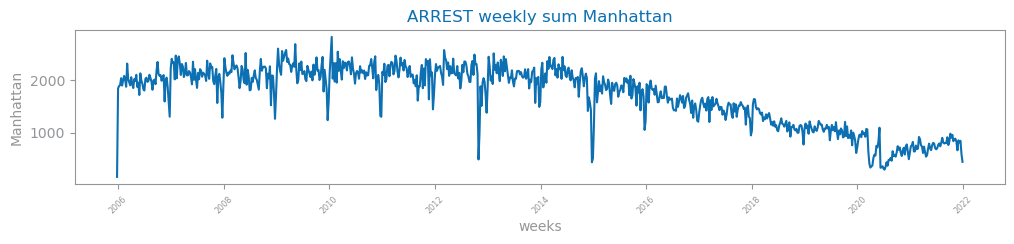

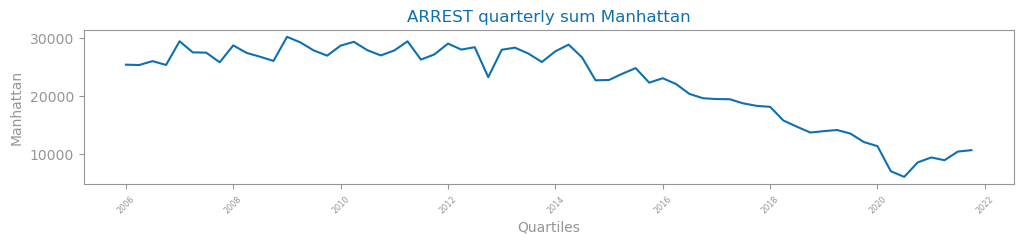

In [4]:
def ts_aggregation_by(
    data: Series | DataFrame,
    gran_level: str = "D",
    agg_func: str = "mean",
) -> Series | DataFrame:
    df: Series | DataFrame = data.copy()
    index: Index[Period] = df.index.to_period(gran_level)
    df = df.groupby(by=index, dropna=True, sort=True).agg(agg_func)
    df.index.drop_duplicates()
    df.index = df.index.to_timestamp()

    return df

ss_weeks: Series = ts_aggregation_by(series, "W", "sum")
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss_weeks.index.to_list(),
    ss_weeks.to_list(),
    xlabel="weeks",
    ylabel=target,
    title=f"{file_tag} weekly sum {target}",
)
show()

# ss_months: Series = ts_aggregation_by(series, "M", "sum")
# figure(figsize=(3 * HEIGHT, HEIGHT / 2))
# plot_line_chart(
#     ss_months.index.to_list(),
#     ss_months.to_list(),
#     xlabel="Months",
#     ylabel=target,
#     title=f"{file_tag} monthly sum {target}",
# )
# show()

ss_quarters: Series = ts_aggregation_by(series, "Q", "sum")
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss_quarters.index.to_list(),
    ss_quarters.to_list(),
    xlabel="Quartiles",
    ylabel=target,
    title=f"{file_tag} quarterly sum {target}",
)
show()

### Distribution

Text(0.2, 0, 'count       64.000000\nmean     22353.640625\nstd       6907.144459\nmin       6124.000000\n25%      18324.250000\n50%      25437.000000\n75%      27810.500000\nmax      30260.000000\nName: Manhattan, dtype: float64')

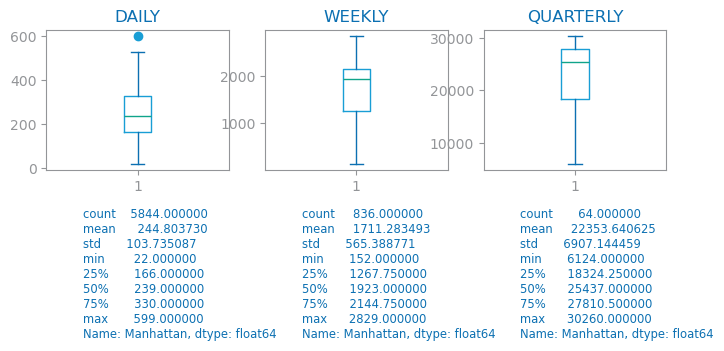

In [5]:
fig: Figure
axs: array
fig, axs = subplots(2, 3, figsize=(2 * HEIGHT, HEIGHT))
set_chart_labels(axs[0, 0], title="DAILY")
axs[0, 0].boxplot(series)
set_chart_labels(axs[0, 1], title="WEEKLY")
axs[0, 1].boxplot(ss_weeks)
# set_chart_labels(axs[0, 2], title="MONTHLY")
# axs[0, 2].boxplot(ss_months)
set_chart_labels(axs[0, 2], title="QUARTERLY")
axs[0, 2].boxplot(ss_quarters)


axs[1, 0].grid(False)
axs[1, 0].set_axis_off()
axs[1, 0].text(0.2, 0, str(series.describe()), fontsize="small")

axs[1, 1].grid(False)
axs[1, 1].set_axis_off()
axs[1, 1].text(0.2, 0, str(ss_weeks.describe()), fontsize="small")

# axs[1, 2].grid(False)
# axs[1, 2].set_axis_off()
# axs[1, 2].text(0.2, 0, str(ss_months.describe()), fontsize="small")

axs[1, 2].grid(False)
axs[1, 2].set_axis_off()
axs[1, 2].text(0.2, 0, str(ss_quarters.describe()), fontsize="small")

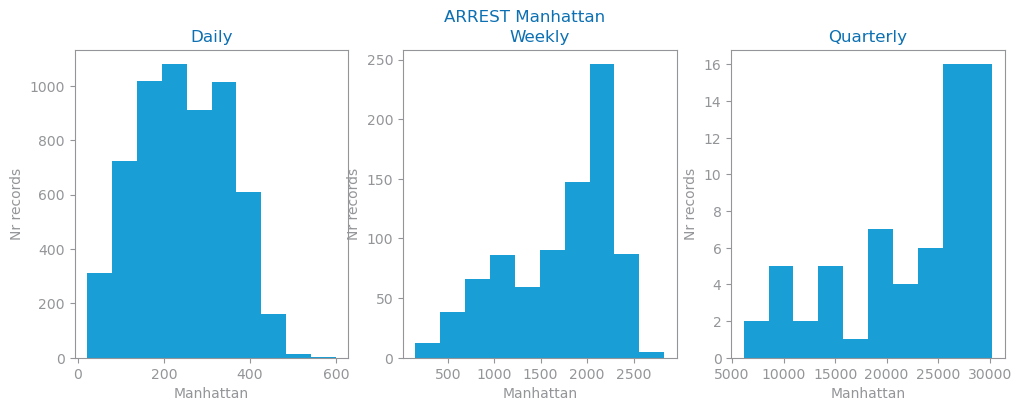

In [6]:
grans: list[Series] = [series, ss_weeks, ss_quarters]
gran_names: list[str] = ["Daily", "Weekly", "Quarterly"]
fig: Figure
axs: array
fig, axs = subplots(1, len(grans), figsize=(len(grans) * HEIGHT, HEIGHT))
fig.suptitle(f"{file_tag} {target}")
for i in range(len(grans)):
    set_chart_labels(axs[i], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[i].hist(grans[i].values)
show()

<Axes: xlabel='Data', ylabel='Manhattan'>

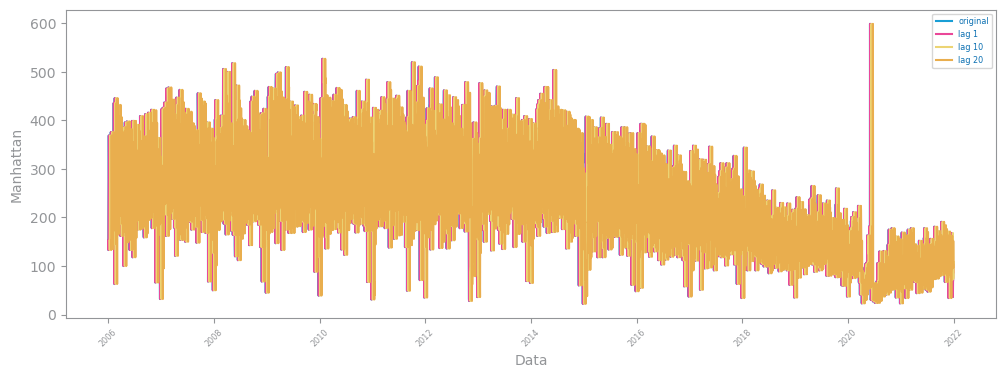

In [7]:
def get_lagged_series(series: Series, max_lag: int, delta: int = 1):
    lagged_series: dict = {"original": series, "lag 1": series.shift(1)}
    for i in range(delta, max_lag + 1, delta):
        lagged_series[f"lag {i}"] = series.shift(i)
    return lagged_series


figure(figsize=(3 * HEIGHT, HEIGHT))
lags = get_lagged_series(series, 20, 10)
plot_multiline_chart(series.index.to_list(), lags, xlabel="Data", ylabel=target)

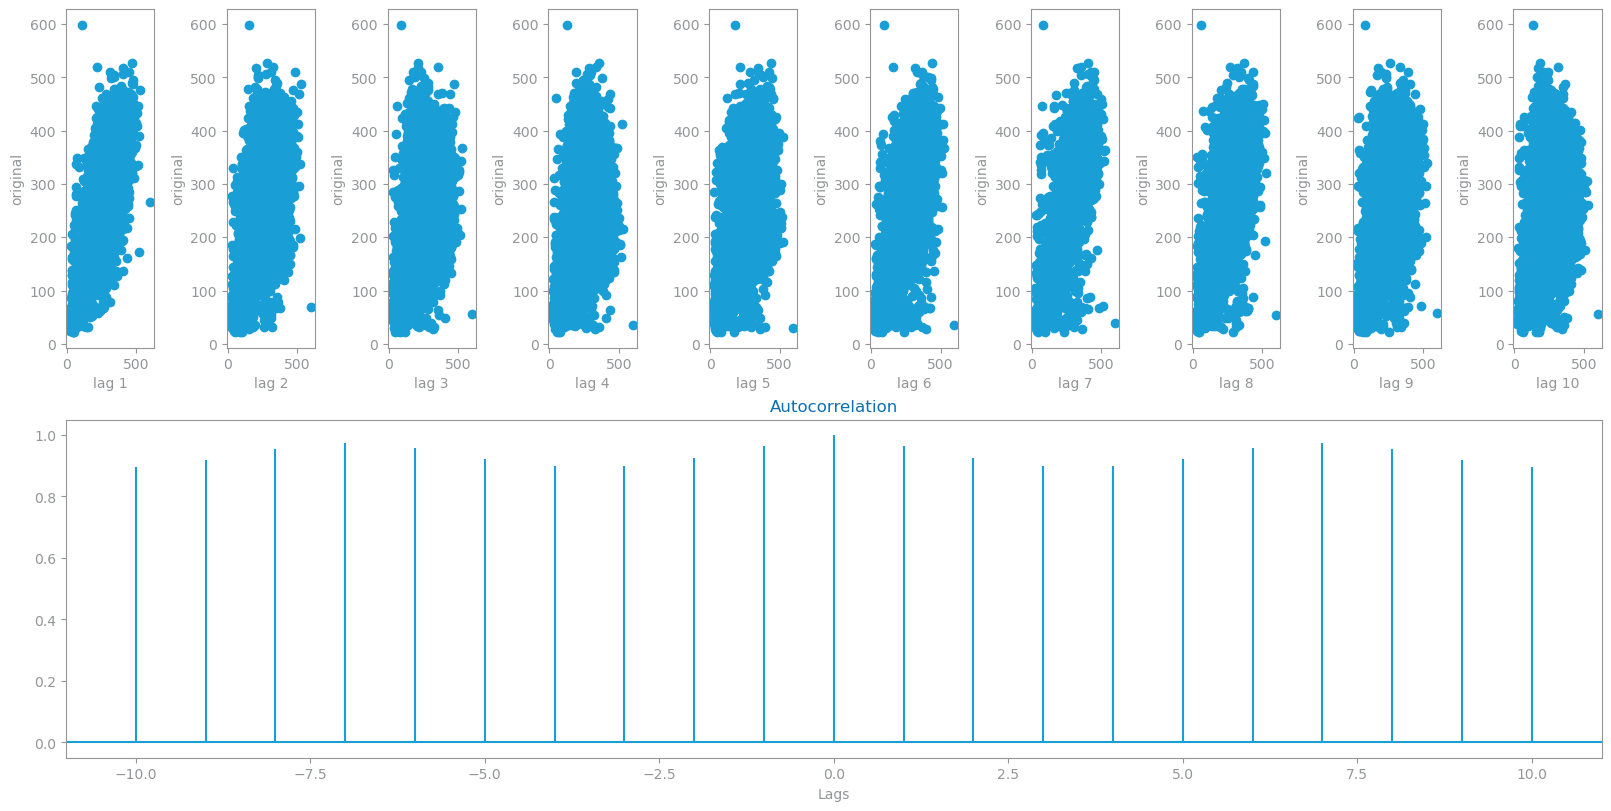

In [8]:
def autocorrelation_study(series: Series, max_lag: int, delta: int = 1):
    k: int = int(max_lag / delta)
    fig = figure(figsize=(4 * HEIGHT, 2 * HEIGHT), constrained_layout=True)
    gs = GridSpec(2, k, figure=fig)

    series_values: list = series.tolist()
    for i in range(1, k + 1):
        ax = fig.add_subplot(gs[0, i - 1])
        lag = i * delta
        ax.scatter(series.shift(lag).tolist(), series_values)
        ax.set_xlabel(f"lag {lag}")
        ax.set_ylabel("original")
    ax = fig.add_subplot(gs[1, :])
    ax.acorr(series, maxlags=max_lag)
    ax.set_title("Autocorrelation")
    ax.set_xlabel("Lags")
    return


autocorrelation_study(series, 10, 1)

### Stationarity

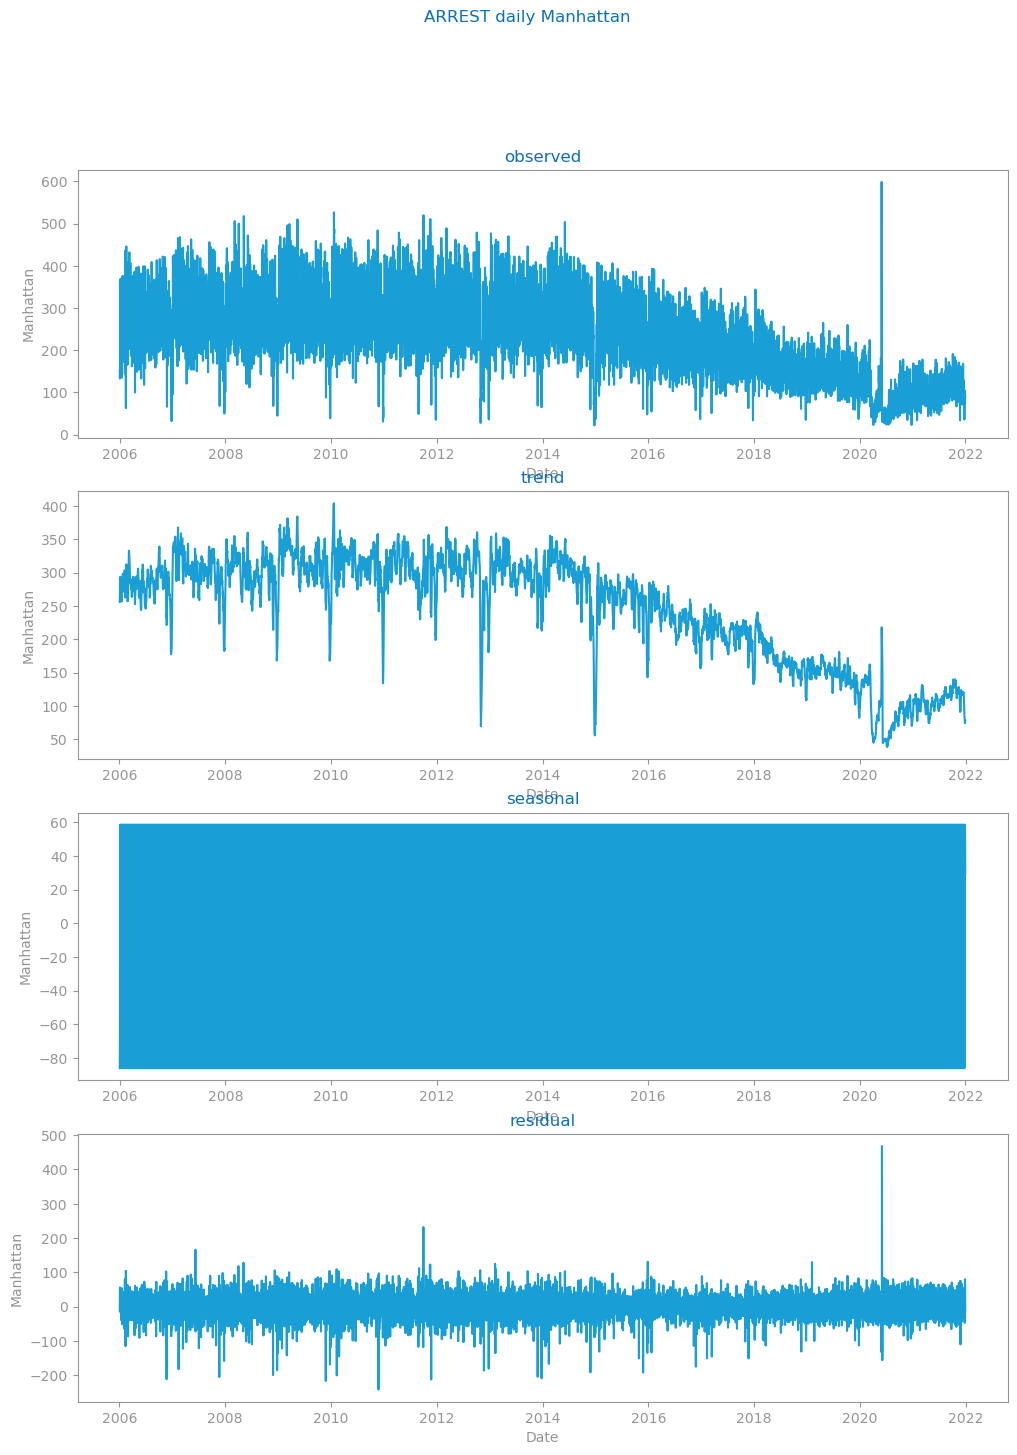

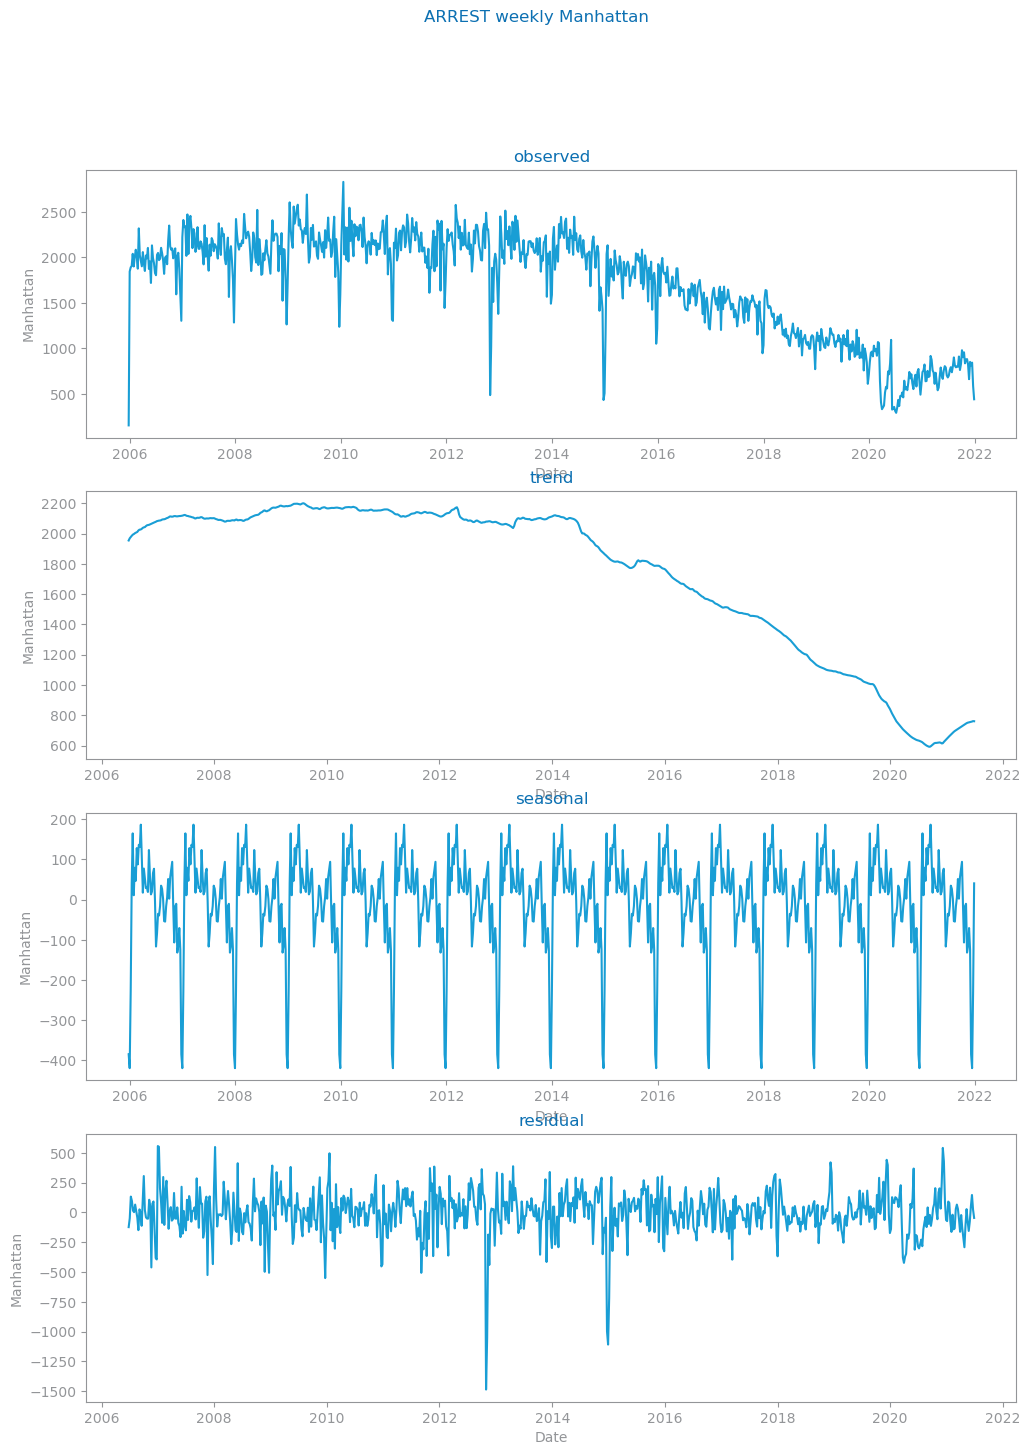

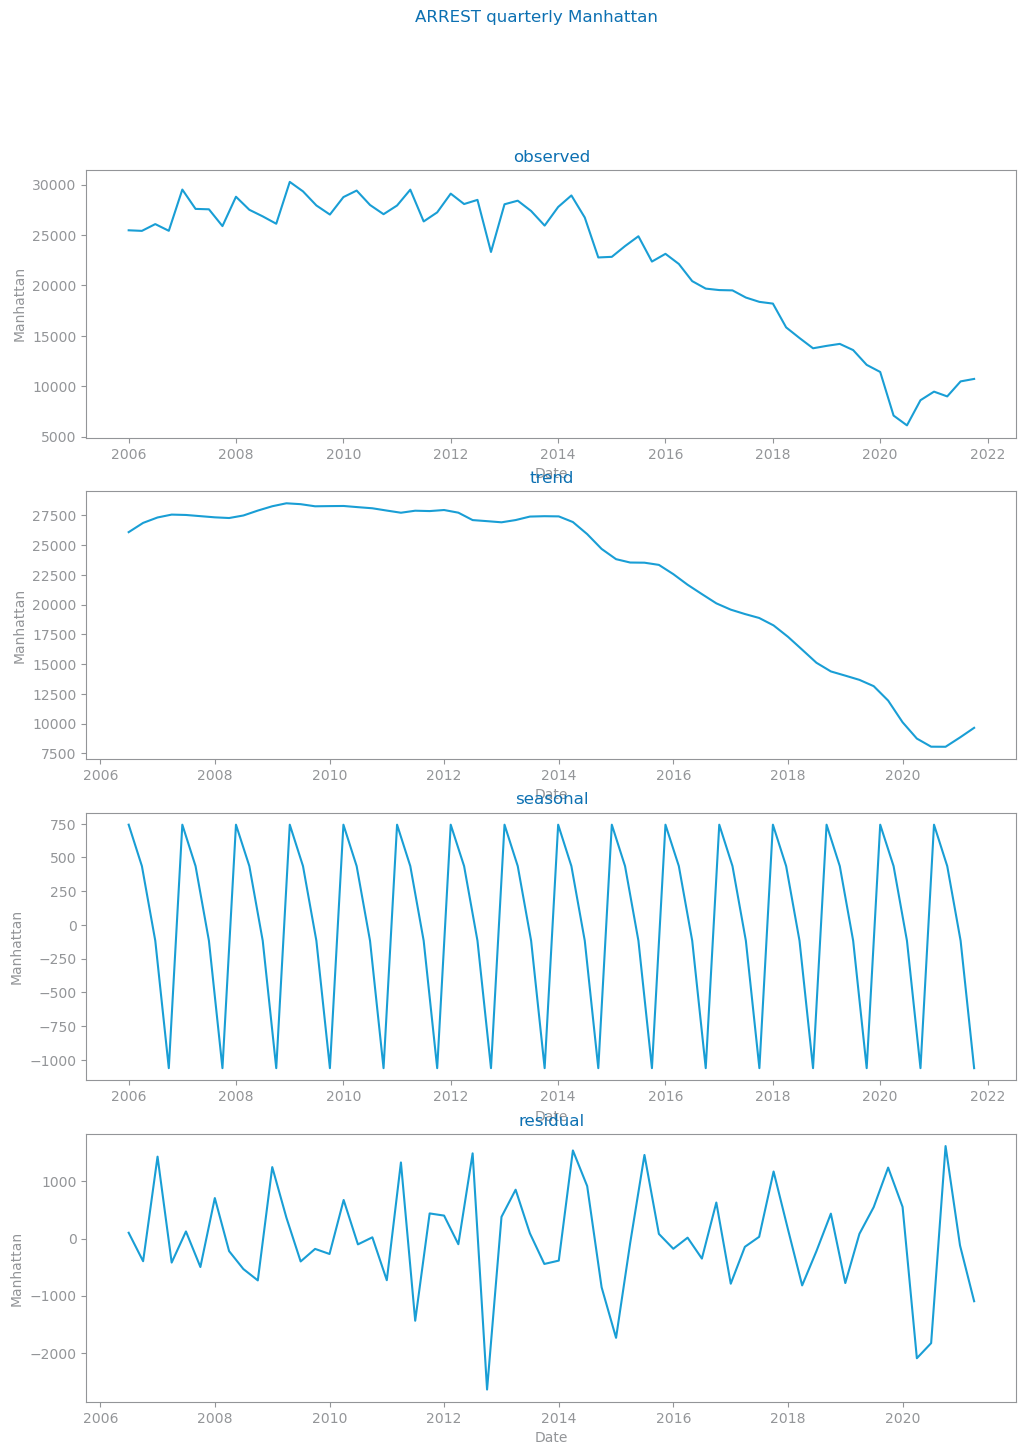

In [9]:
def plot_components(
    series: Series,
    title: str = "",
    x_label: str = "time",
    y_label: str = "",
) -> list[Axes]:
    decomposition: DecomposeResult = seasonal_decompose(series, model="add")
    components: dict = {
        "observed": series,
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "residual": decomposition.resid,
    }
    rows: int = len(components)
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(rows, 1, figsize=(3 * HEIGHT, rows * HEIGHT))
    fig.suptitle(f"{title}")
    i: int = 0
    for key in components:
        set_chart_labels(axs[i], title=key, xlabel=x_label, ylabel=y_label)
        axs[i].plot(components[key])
        i += 1
    return axs

plot_components(
    series,
    title=f"{file_tag} daily {target}",
    x_label=series.index.name,
    y_label=target,
)
show()

plot_components(
    ss_weeks,
    title=f"{file_tag} weekly {target}",
    x_label=ss_weeks.index.name,
    y_label=target,
)
show()

plot_components(
    ss_quarters,
    title=f"{file_tag} quarterly {target}",
    x_label=ss_weeks.index.name,
    y_label=target,
)
show()

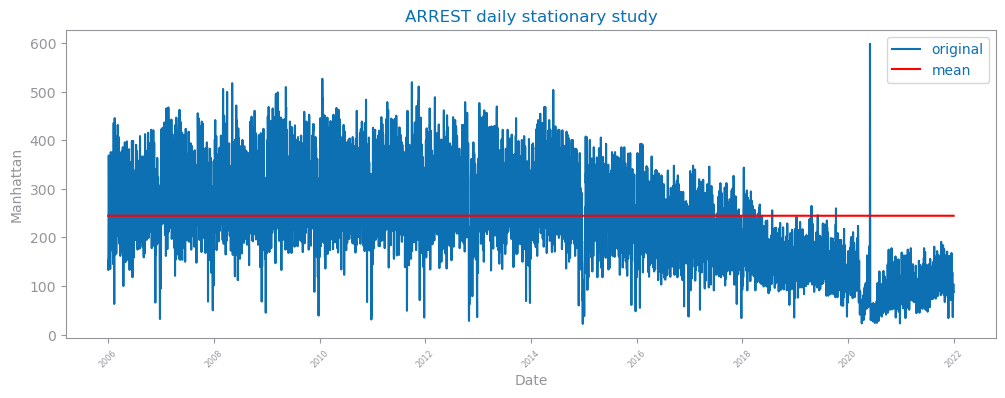

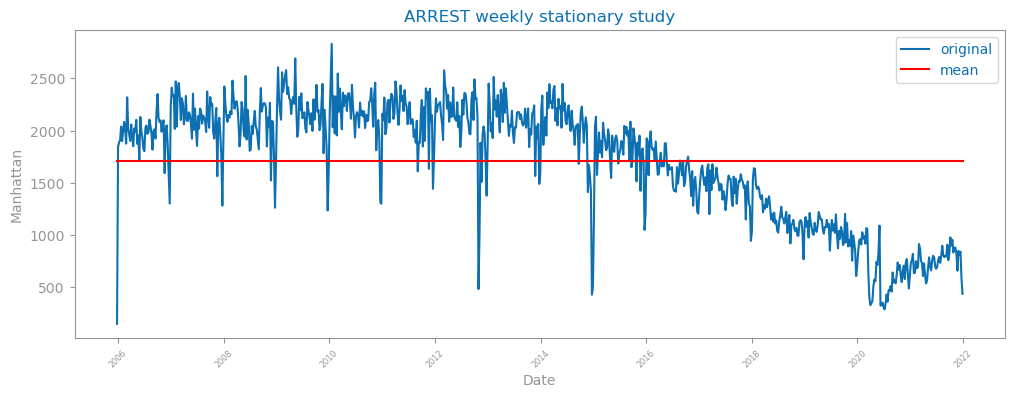

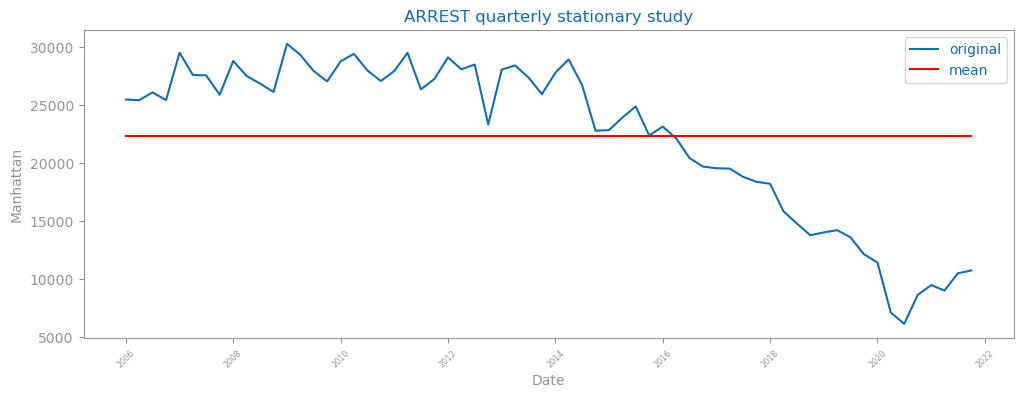

In [10]:
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} daily stationary study",
    name="original",
)
n: int = len(series)
plot(series.index, [series.mean()] * n, "r-", label="mean")
legend()
show()

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_weeks.index.to_list(),
    ss_weeks.to_list(),
    xlabel=ss_weeks.index.name,
    ylabel=target,
    title=f"{file_tag} weekly stationary study",
    name="original",
)
n: int = len(ss_weeks)
plot(ss_weeks.index, [ss_weeks.mean()] * n, "r-", label="mean")
legend()
show()

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_quarters.index.to_list(),
    ss_quarters.to_list(),
    xlabel=ss_quarters.index.name,
    ylabel=target,
    title=f"{file_tag} quarterly stationary study",
    name="original",
)
n: int = len(ss_quarters)
plot(ss_quarters.index, [ss_quarters.mean()] * n, "r-", label="mean")
legend()
show()

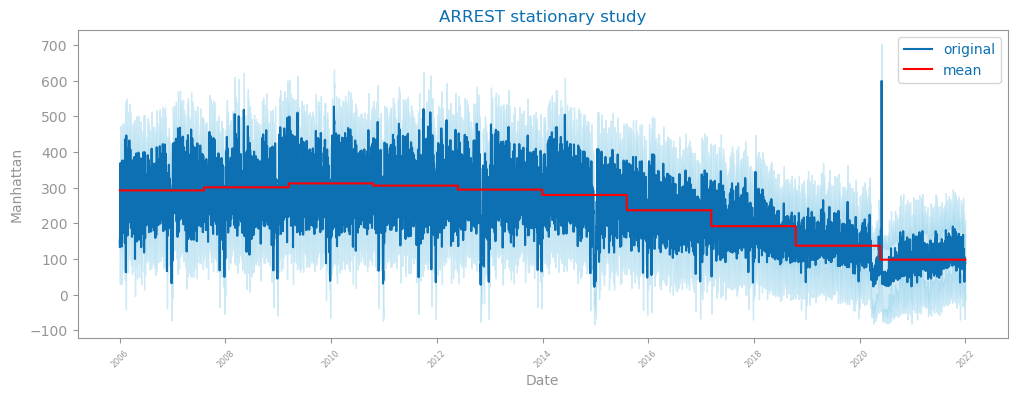

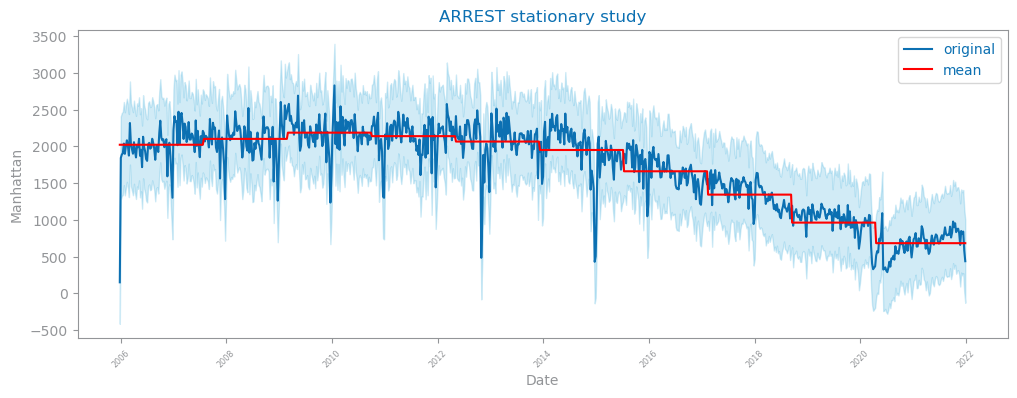

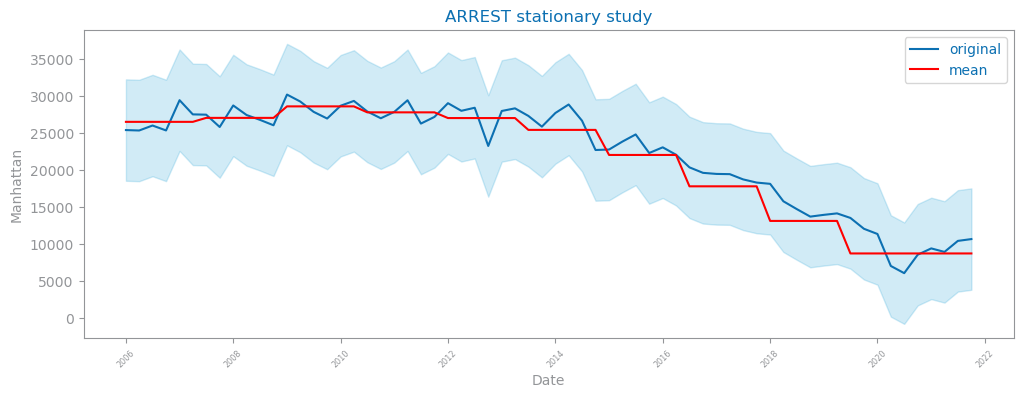

In [11]:
def plot_stationary_study(series):
    BINS = 10
    mean_line: list[float] = []
    n: int = len(series)

    for i in range(BINS):
        segment: Series = series[i * n // BINS : (i + 1) * n // BINS]
        mean_value: list[float] = [segment.mean()] * (n // BINS)
        mean_line += mean_value
    mean_line += [mean_line[-1]] * (n - len(mean_line))

    figure(figsize=(3 * HEIGHT, HEIGHT))
    plot_line_chart(
        series.index.to_list(),
        series.to_list(),
        xlabel=series.index.name,
        ylabel=target,
        title=f"{file_tag} stationary study",
        name="original",
        show_stdev=True,
    )
    n: int = len(series)
    plot(series.index, mean_line, "r-", label="mean")
    legend()
    show()

plot_stationary_study(series)

plot_stationary_study(ss_weeks)

plot_stationary_study(ss_quarters)

In [12]:
def eval_stationarity(series: Series) -> bool:
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    return result[1] <= 0.05


print(f"The series {('is' if eval_stationarity(series) else 'is not')} stationary")

print(f"The series {('is' if eval_stationarity(ss_weeks) else 'is not')} stationary")

print(f"The series {('is' if eval_stationarity(ss_quarters) else 'is not')} stationary")

ADF Statistic: -1.887
p-value: 0.338
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The series is not stationary
ADF Statistic: -0.200
p-value: 0.939
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
The series is not stationary
ADF Statistic: -1.097
p-value: 0.716
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597
The series is not stationary
